### Table of contents:

* [Upload needed data](#upload)
* [Parameters calibration with exogenous variables](#pal_cal)
    * [Companies](#pal_cal_com)
    * [Technologies](#pal_cal_tech)
* [Rank](#rank)
    * [Companies](#rank_com)
    * [Technologies](#rank_tech)
* [Keep track of the optimal parameters and the number of iterations](#track)    

In [1]:
import math
import arrow
import ipynb 
import os.path
import json
import pickle
import sys
import random
import operator

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import numpy as np

from dotenv import load_dotenv
from networkx.algorithms.bipartite.matrix import biadjacency_matrix
from networkx.algorithms import bipartite
from importlib import reload
from typing import List


In [24]:
# import functions from py file 

import functions.fun
reload(functions.fun)
from functions.fun import CB_data_cleaning, df_from_api_CB, extract_nodes, extract_data_from_column
from functions.fun import nx_dip_graph_from_pandas, filter_dict, check_desc
from functions.fun import extract_classes_company_tech, degree_bip, insert_data_classes

In [25]:
# import functions from py file 

import functions.fun_meth_reflections
reload(functions.fun_meth_reflections)
from functions.fun_meth_reflections import zero_order_score, Gct_beta, Gtc_alpha, make_G_hat, next_order_score, generator_order_w
from functions.fun_meth_reflections import M_test_triangular, w_stream, find_convergence, rank_df_class, w_star_analytic

In [26]:
# import functions from py file 

import functions.fun_external_factors
reload(functions.fun_external_factors)
from functions.fun_external_factors import rank_comparison, calibrate_analytic, create_exogenous_rank

In [7]:
# import classes 

import classes
reload(classes)

<module 'classes' from '/home/anita.mezzetti/bipartite_network/classes.py'>

## Upload data <a class="anchor" id="upload"></a>

Data in the right structure are created in `create_network_dictionaries.ipynb`. In that notebook, we upload the CSV file of the data of CB, we clean the data and we create two dictionaries and a networkx graph:
- dict_companies: dictionary containing all the information about companies 
    name_company: Company
- dict_tech: dictionary containing all the information about technologies 
    name_tech: Tehcnology
- B: bipartite graph of companies and technologies

In [8]:
# imputs! 
# change them and teh rest of the code will react accordingly
# please make sure to match the num of companies with the right number of technologies

num_com = 10
num_tech = 26

preferences_comp = {"previous_investments":100,
                    "crunchbase_rank":0}

In [9]:
name_file_com = f'savings/classes/dict_companies_cybersecurity_{num_com}.pickle'
name_file_tech = f'savings/classes/dict_companies_cybersecurity_{num_com}.pickle'
name_file_graph = f'savings/networks/cybersecurity_comp_{num_com}_tech_{num_tech}.gpickle'
name_M = f'savings/M/cybersecurity_comp_{num_com}_tech_{num_tech}.npy'
flag_cybersecurity = True

In [10]:
with open(name_file_com, 'rb') as f:
    dict_companies = pickle.load(f)
    
with open(name_file_tech, 'rb') as f:
    dict_tech = pickle.load(f)

B = nx.read_gpickle(name_file_graph)

with open(name_M, 'rb') as f:
    M = np.load(f)

## Parameters calibration with exogenous variables.  <a class="anchor" id="pal_cal"></a>

An essential step is the calibration of $\alpha$ and $\beta$, i.e. find the *optimal* parameters that maximise our correlation between model and actual. 

We decide to perform just a **grid search**, defining a way to compare our list rankings using the Spearman method from `scipy.stats`. So, we define a landscape, $[-2,2] \times [-2,2]$, and evaluate at all those points (using the analytic method). Finally we will return the top correlation we found.

NB: also for this step, we take inspiration by the work by Klein, Maillart, and Chuang.

**Companies**  <a class="anchor" id="pal_cal_com"></a>

/home/anita.mezzetti/miniconda3/envs/arma/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


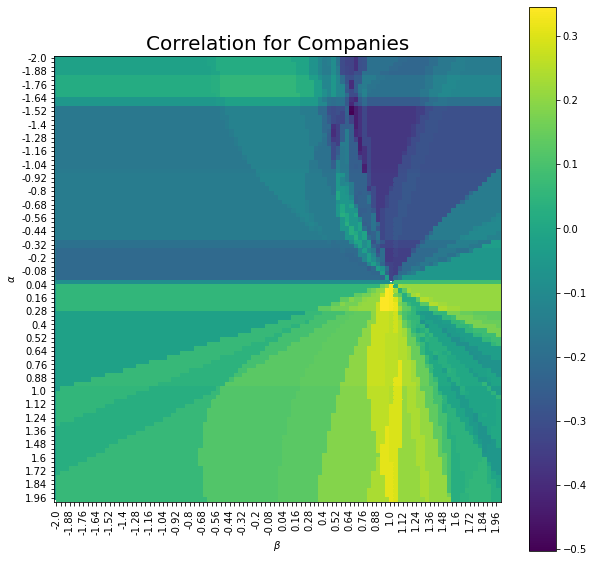

In [12]:
best_par = calibrate_analytic(M=M,
                   ua='Companies',
                   dict_class=dict_companies, 
                   exogenous_rank=create_exogenous_rank('Companies', dict_companies, preferences_comp), 
                   index_function=lambda x: (x-50)/25,
                   title='Correlation for Companies',
                   do_plot=True)

In [13]:
# highlight bets alpha and beta
best_alpha_comp = best_par['alpha']
best_beta_comp = best_par['beta']

**Technologies**  <a class="anchor" id="pal_cal_tech"></a>

In [14]:
# highlight bets alpha and beta
best_alpha_tech = 0.2
best_beta_tech = 0.2

## Rank <a class="anchor" id="rank"></a>

In [15]:
set0 = extract_nodes(B, 0)
set1 = extract_nodes(B, 1)

# adjacency matrix of bipartite graph
adj_matrix = biadjacency_matrix(B, set0, set1)

In [16]:
adj_matrix_dense = adj_matrix.todense()

**Representation**

In [17]:
a = np.squeeze(np.asarray(adj_matrix_dense))
#a.sum(axis=1)

In [18]:
# M is the array version of the matrix adj_matrix_dense:
M = np.squeeze(np.asarray(adj_matrix_dense))

In [19]:
# save M in order to use it in other scripts

if flag_cybersecurity==False: # all fields
    name_file_M = 'savings/M/comp_' + str(len(dict_companies)) + '_tech_' + str(len(dict_tech)) + '.npy'                                     
else: # only companies in cybersecurity
    name_file_M = 'savings/M/cybersecurity_comp_'+ str(len(dict_companies)) + '_tech_' + str(len(dict_tech)) + '.npy'

np.save(name_file_M, M)

### Triangularize matrix

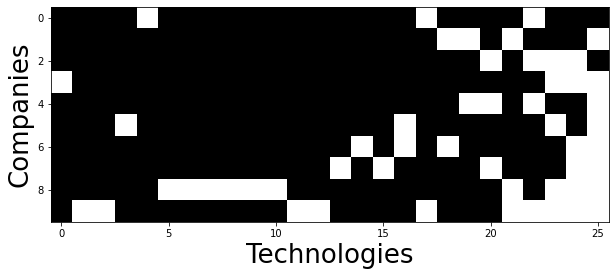

In [20]:
M_test_triangular(adj_matrix_dense, flag_cybersecurity)

### Zero order score

These are an $w_{c}$ editor-vector which is the sums of articles edited by each editor. Or the article-vector $w_{p}$, which is the sum of editors contributing to each article.

\begin{cases}
 w_{c}^{(0)} = \sum_{p=1}^{N_{p}} M \equiv k_c\\[7pt]
 w_{p}^{(0)} = \sum_{c=1}^{N_{c}} M \equiv k_p
\end{cases}

In [21]:
k_c, k_t = zero_order_score(M)

### G - transition probability function

Depending on $\alpha$ and $\beta$ we non-linearly weight based on the Zeroth order iterations. 

\begin{cases}
G_{ct}(\beta) = \frac{M_{ct} k_{c}^{-\beta}}{\sum_{c' = 1}^{N_c} M_{c't} k_{c'}^{-\beta}}\\[10pt]
G_{tc}(\alpha) = \frac{M_{ct} k_{t}^{-\alpha}}{\sum_{t' = 1}^{N_t} M_{ct'} k_{t'}^{-\alpha}}.\\\end{cases}

### Higher cases

The first order $w^{1}_c$ is the sum of the articles touched, but weighted by the Zeroth order article-vector (and the $G$ term). So if you've edited better articles that counts. And $w^{1}_c$ is the sum of editors touching, but weighted by the Zeroth order editor-vector (and $G$). So if you're touched by better editors that's also being considered. 

Beyond the first order interpretation for the higher orders is difficult.

\begin{cases}
w^{(n+1)}_c (\alpha,\beta) = \sum_{t=1}^{N_p}  G_{ct}(\beta) \,w^{(n)}_t (\alpha,\beta)\\[7pt]
w^{(n+1)}_t (\alpha,\beta) = \sum_{c=1}^{N_c}  G_{tc}(\alpha) \, w^{(n)}_c (\alpha,\beta)\\
\end{cases}

### **Companies**  <a class="anchor" id="rank_com"></a>

converge at 46
36


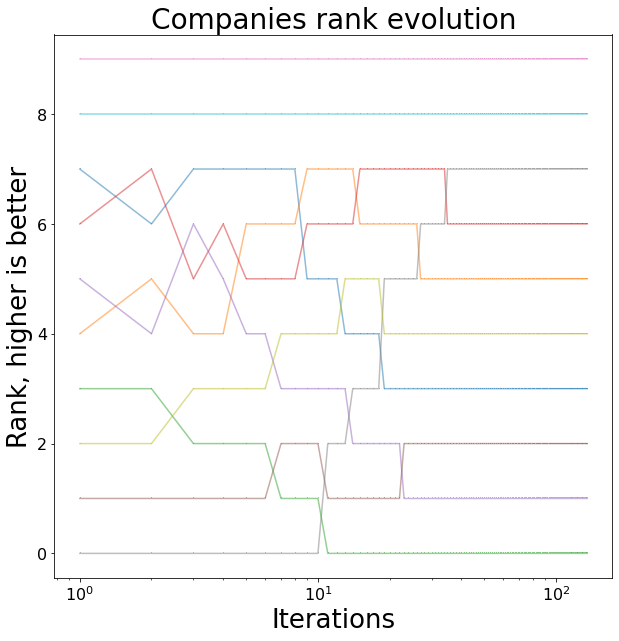

In [27]:
convergence_comp = find_convergence(M,
                                    alpha=best_alpha_comp, 
                                    beta=best_beta_comp, 
                                    fit_or_ubiq='fitness', 
                                    do_plot=True, 
                                    flag_cybersecurity=flag_cybersecurity)

In [28]:
df_final_companies, dict_companies = rank_df_class(convergence_comp, dict_companies)

In [29]:
convergence_comp

{'fitness': array([5.22110324, 5.31069755, 5.08023901, 5.33772911, 5.13207247,
        5.14756637, 5.63681121, 5.34684724, 5.24597354, 5.54096026]),
 'iteration': 36,
 'initial_conf': array([7, 4, 3, 6, 5, 1, 9, 0, 2, 8]),
 'final_conf': array([3, 5, 0, 6, 1, 2, 9, 7, 4, 8])}

In [30]:
# relative rank
df_final_companies['final_rank_normlized'] = df_final_companies['final_rank']/np.max(list(df_final_companies['final_rank']))*10
n = np.max(df_final_companies['rank_CB']) + 1
df_final_companies['rank_CB_normlized'] = n - df_final_companies['rank_CB']

df_final_companies['TeckRank_int'] = df_final_companies.index + 1.0

In [31]:
df_final_companies

,initial_position,final_configuration,degree,final_rank,rank_CB,final_rank_normlized,rank_CB_normlized,TeckRank_int
0,3,Zscaler,0,5.08,170.0,9.011886,1122.0,1.0
1,5,OPSWAT,0,5.132,528.0,9.104133,764.0,2.0
2,1,Lacework,0,5.148,581.0,9.132517,711.0,3.0
3,7,OneTrust,0,5.221,107.0,9.262019,1185.0,4.0
4,2,Talend,0,5.246,1264.0,9.306369,28.0,5.0
5,4,BigID,0,5.311,152.0,9.421678,1140.0,6.0
6,6,AppOmni,0,5.338,280.0,9.469576,1012.0,7.0
7,0,G4S,0,5.347,988.0,9.485542,304.0,8.0
8,8,1Password,0,5.541,1291.0,9.829697,1.0,9.0
9,9,Acronis,0,5.637,595.0,10.0,697.0,10.0


In [32]:
df_spearman = df_final_companies[["TeckRank_int", "rank_CB_normlized"]]
df_spearman = df_spearman.astype(float)
df_spearman["name"] = df_final_companies['final_configuration']
df_spearman.set_index("name")

,TeckRank_int,rank_CB_normlized
name,,
Zscaler,1.0,1122.0
OPSWAT,2.0,764.0
Lacework,3.0,711.0
OneTrust,4.0,1185.0
Talend,5.0,28.0
BigID,6.0,1140.0
AppOmni,7.0,1012.0
G4S,8.0,304.0
1Password,9.0,1.0


In [33]:
df_spearman

,TeckRank_int,rank_CB_normlized,name
0,1.0,1122.0,Zscaler
1,2.0,764.0,OPSWAT
2,3.0,711.0,Lacework
3,4.0,1185.0,OneTrust
4,5.0,28.0,Talend
5,6.0,1140.0,BigID
6,7.0,1012.0,AppOmni
7,8.0,304.0,G4S
8,9.0,1.0,1Password
9,10.0,697.0,Acronis


In [34]:
# save df
name = "csv_results/complete_companies_" + str(len(dict_companies)) + ".csv"
df_final_companies.to_csv(name, index = False, header=True)

**Sperman correlation**

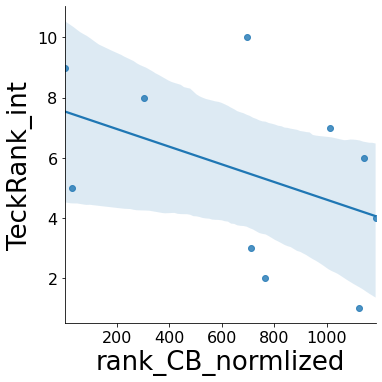

In [35]:
sns.lmplot(x="rank_CB_normlized", y="TeckRank_int", data=df_spearman)
plt.show()

In [36]:
df_spearman.corr(method='spearman')

,TeckRank_int,rank_CB_normlized
TeckRank_int,1.00000,-0.50303
rank_CB_normlized,-0.50303,1.00000


### **Technologies**  <a class="anchor" id="rank_tech"></a>

converge at 35
25


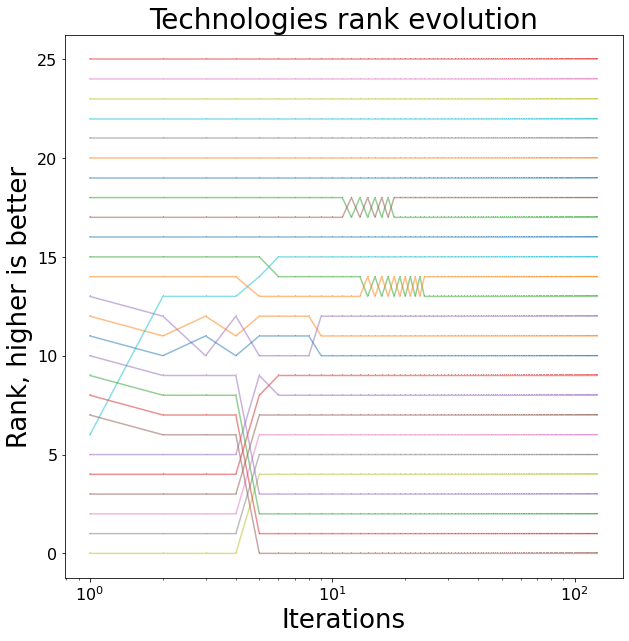

In [40]:
convergence_tech = find_convergence(M,
                                    alpha=best_alpha_tech, 
                                    beta=best_beta_tech, 
                                    fit_or_ubiq='ubiquity', 
                                    do_plot=True, 
                                    flag_cybersecurity=flag_cybersecurity)

In [41]:
df_final_tech, dict_tech = rank_df_class(convergence_tech, dict_tech)

In [42]:
df_final_tech

,initial_position,final_configuration,degree,final_rank,rank_CB
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN


In [43]:
# save df
name = "csv_results/complete_tech_" + str(len(dict_tech)) + ".csv"

df_final_tech.to_csv(name, index = False, header=True)

### Keep track of the optimal parameters and the number of iterations <a class="anchor" id="track"></a>

In a dataframe file we track the optimal parameters in each case (number of companies/technologies and preferences), in order to have track of everything 
